# Twin-Delayed DDPG for Bipedal Walker

The goal of this project is to implement Twin-Delayed DDPG (TD3) algorithm for BipedalWalker environment in OpenAi Gym. Twin-Delayed DDPG is an actor-critic framework which achieves state of the art performance for continuous control. While applying two critic networks, TD3 are able to select the smaller of the two predictions as the target q-value, and thus recude the over-estimation of the q-function. Next, TD3 delays the update of actor network to prevent policy function from varying too frequently. TD3 adds gaussian noise in action selection for action exploration during training, and the noise is clipped within boundaries. We also applies tricks such as target networks, huber loss, and soft update for stabilizing the training process.

---
The implementation is based on the following paper:
- [Addressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/abs/1802.09477)

### 1. prepare environment

- Switch to tensorflow 2
- Install dependencies
- Import tensorflow, gym, matplotlib...

In [ ]:
# set tensorflow version 2
%tensorflow_version 2.x

In [ ]:
# install dependencies
!pip install -q gym box2d-py pyvirtualdisplay
!apt-get install -qq xvfb python-opengl ffmpeg

     |████████████████████████████████| 450kB 8.6MB/s 
Selecting previously unselected package python-opengl.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
# import modules
import tensorflow as tf
import numpy as np
from collections import deque

import gym
from gym import wrappers

import glob
import base64
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

In [ ]:
# create display window for OpenAi gym
display = Display(visible=0, size=(640, 480))
display.start()

### 2. explore OpenAi Gym environment

- The [BipedalWalker-v3](https://gym.openai.com/envs/BipedalWalker-v2/) environment is from [OpenAi Gym](https://gym.openai.com/)

- The goal of this environment is to drive the Bipedal Walker to walk along the path witout falling down. This task is considered solved if the agent received average +300 reward within 1600 time step.

- The 24 states represent:
    - the x and y velocities
    - the angle and angular velocities for the joints of hull, hips, kees, and legs
    - ground_contact of legs
    - 10 lidar readings for the distance to the ground
<p align="center">
  <img src="https://github.com/ChienTeLee/td3_bipedal_walker/raw/master/doc/figure0.png" width="50%" height="50%"> 
</p>

- The 4 actions represent torque control of:
    - Hip_1
    - Knee_1
    - Hip_2
    - Knee_2
<p align="center">
  <img src="https://github.com/ChienTeLee/td3_bipedal_walker/raw/master/doc/figure1.png" width="50%" height="50%"> 
</p>

- Moving forward receives total over +300 points to the far end. The robot recieves -100 points if it falls down. Applying torque to joints costs a small amount of points (around -0.02 points).

- We first play the untrained Bipedal Walker for 5 times and record the simulation video in "./before_train". The simulation result looks like this:
<p align="center">
  <img src="https://github.com/ChienTeLee/td3_bipedal_walker/raw/master/doc/before_train.gif" width="50%" height="50%"> 
</p>
- We cans see that the Bipedal Walker cannot land well on landing pad, and the average reward before training is around -100.


In [ ]:
# create OpenAi Gym environment
env = gym.make("BipedalWalker-v3")
env = wrappers.Monitor(env, "./before_train", force=True, video_callable=lambda episode: (episode+1)>0)
print("state space: " + str(env.observation_space))
print("action space: " + str(env.action_space))

state space: Box(24,)
action space: Box(4,)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# play with untrained Bipedal Walker and record
total_reward_history = []
for i in range(5):
    state = env.reset()
    total_reward = 0
    while True:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            total_reward_history.append(total_reward)
            break

env.close()

avg_reward = np.mean(total_reward_history)
print("Average reward before training = {}".format(avg_reward))

Average reward before training = -97.28602598899124


In [ ]:
def play_video(path):
    """
    Display videos in the folder at colab notebook terminal.

    Args:
        path (str): Path to the video folder. All videos in the folder will be played.
        
    Returns:
        None
    """
    video_list = glob.glob(path + "/*.mp4")
    html = []
    for file in video_list:
        video = open(file, 'rb').read()
        base64_video = base64.b64encode(video).decode('ascii')
        data_uri = "data:video/mp4;base64," + base64_video
        video_tag = '''
        <video width="640" height="480" autoplay loop>
            <source src={} type="video/mp4">
        </video>'''.format(data_uri)
        html.append(video_tag)
    html_tag = "<br>".join(html)
    ipythondisplay.display(ipythondisplay.HTML(html_tag))

In [ ]:
video_path = "./before_train"
play_video(video_path)

### 2. create Actor Critic network class

- Here we create actor and critic networks for Twin-Delayed DDPG. The actor takes the state and predicts the action. The critic takes state and action to predict estimated q-value.

- The network architecture is shown in the following diagram:
<p align="center">
  <img src="https://github.com/ChienTeLee/td3_bipedal_walker/raw/master/doc/figure2.png" width="55%" height="55%"> 
</p>


In [ ]:
class Actor_Network(tf.keras.Model):
    """
    The keras model for actor network which takes state and output action.

    Attributes:
        dense_1 (tf.keras.layers.Dense) : First dense layer with relu activation.
        dense_2 (tf.keras.layers.Dense) : Second dense layer with relu activation.
        dense_3 (tf.keras.layers.Dense) : Third dense layer with tanh activation.
    """

    def __init__(self, n_state, n_action, hidden_1=400, hidden_2=300):
        """
        The __init__ method for Actor_Network class.

        Args:
            n_state (int): Number of states for input node.
            n_action (int): Number of actions for output node.
            hidden_1 (int): Number of hidden nodes for the first dense layer.
            hidden_2 (int): Number of hidden nodes for the second dese layer.
        """
        super().__init__()
        self.dense_1 = tf.keras.layers.Dense(hidden_1, 'relu', name='dense_1')
        self.dense_2 = tf.keras.layers.Dense(hidden_2, 'relu', name='dense_2')
        self.dense_3 = tf.keras.layers.Dense(n_action, 'tanh', name='dense_3')

        # build and call network
        self.build((None, n_state))
        inputs = tf.keras.Input(shape=n_state)
        self.call(inputs)

    def call(self, inputs):
        """
        The call method for Actor_Network class.

        Args:
            inputs (tf.Tensor): The state input to the network.
        
        Returns:
            output (tf.Tensor): The action output of the network.
        """
        dense_1_out = self.dense_1(inputs)
        dense_2_out = self.dense_2(dense_1_out)
        output = self.dense_3(dense_2_out)
        return output

In [ ]:
class Critic_Network(tf.keras.Model):
    """
    The keras model for critic network which takes state, action and outputs estimated q-value.

    Attributes:
        dense_1 (tf.keras.layers.Dense) : First dense layer with relu activation.
        dense_2 (tf.keras.layers.Dense) : Second dense layer with relu activation.
        dense_3 (tf.keras.layers.Dense) : Third dense layer with linear activation.
    """

    def __init__(self, n_state, n_action, hidden_1=400, hidden_2=300):
        """
        The __init__ method for Critic_Network class.

        Args:
            n_state (int): Number of states for input node.
            n_action (int): Number of actions for output node.
            hidden_1 (int): Number of hidden nodes for the first dense layer.
            hidden_2 (int): Number of hidden nodes for the second dese layer.
        """
        super().__init__()
        self.dense_1 = tf.keras.layers.Dense(hidden_1, 'relu', name='dense_1')
        self.dense_2 = tf.keras.layers.Dense(hidden_2, 'relu', name='dense_2')
        self.dense_3 = tf.keras.layers.Dense(1, 'linear', name='dense_3')

        # build and call network
        self.build([(None, n_state), (None, n_action)])
        state= tf.keras.Input(shape=n_state)
        action= tf.keras.Input(shape=n_action)
        self.call([state, action])

    def call(self, inputs):
        """
        The call method for Critic_Network class.

        Args:
            inputs (list:tf.Tensor): list of tensor containing [state, action]
        
        Returns:
            output (tf.Tensor): The q-value output of the network.
        """
        # input x must be a list of [state, action]
        state = inputs[0]
        action = inputs[1]
        concat = tf.concat([state, action], axis=1)
        dense_1_out = self.dense_1(concat)
        dense_2_out = self.dense_2(dense_1_out)
        output = self.dense_3(dense_2_out)
        return output

### 3. create replay memory class

- The experinces (state, action, reward, next_state, done) are stored in rotation numpy arrays.

- It performs uniform random sampling to select minibatch for experience replay.

In [ ]:
class Replay_Memory(object):
    """
    The Replay_Memory class. The experiences (state, action, reward, next_state, done) are stored in
    rotation numpy arrays.

    Attributes:
        capacity (int): Maximun capacity of the memory.
        batch_size (int): The batch size for sampling experiences.
        n_sample (int): Indicates how many samples has entered the memory from the beginning of time.
        state_mem (ndarray:float): States stored in numpy array.
        action_mem (ndarray:int): Actions stored in numpy array.
        reward_mem (ndarray:float): Rewards stored in numpy array.
        next_state_mem (ndarray:float): Next states stored in numpy array.
        done_mem (ndarray:float): Terminals stored in numpy array.
    """

    def __init__(self, capacity, n_state, n_action, batch_size):
        """
        The __init__ method for Replay_Memory class.

        Args:
            capacity (int): Maximun capacity of the memory
            n_state (int): Number of states.
            n_action (int): Number of actions.
            batch_size (int): The batch size for sampling experiences.
        """
        # set parameters
        self.capacity = capacity
        self.batch_size = batch_size
        self.n_sample = 0

        # store memory in rotation np array
        self.state_mem = np.zeros((capacity, n_state), dtype=np.float32)
        self.action_mem = np.zeros((capacity, n_action), dtype=np.float32)
        self.reward_mem = np.zeros((capacity, 1), dtype=np.float32)
        self.next_state_mem = np.zeros((capacity, n_state), dtype=np.float32)
        self.done_mem = np.zeros((capacity, 1), dtype=np.float32)

    def add(self, state, action, reward, next_state, done):
        """
        Store current experience (state, action, reward, next_state, done) in memory.

        Args:
            state (ndarray:float): Current state of agent.
            action (ndarray:float): Executed action.
            reward (float): The reward when taking action in state.
            next_state (ndarray:float): Next state of agent.
            done (float): 1 indicates terminal state, and 0 indicates non-terminal state.

        Returns:
            None
        """
        # store one transition in memory
        index = self.n_sample % self.capacity
        self.state_mem[index] = state
        self.action_mem[index] = action
        self.reward_mem[index] = reward
        self.next_state_mem[index] = next_state
        self.done_mem[index] = done
        # increase memory count
        self.n_sample = self.n_sample + 1
    
    def get_minibatch(self):
        """
        Random get minibatch samples.

        Args:
            None

        Returns:
            (tuple): tuple containing:
                 states (ndarray:float): Sampled states corresponding to indicies.
                 actions (ndarray:float): Sampled actions corresponding to indicies.
                 rewards (ndarray:float): Sampled rewards corresponding to indicies.
                 next_states (ndarray:float): Sampled next_states corresponding to indicies.
                 dones (ndarray:float): Sampled dones corresponding to indicies.
        """
        # random sample minibatch
        index = np.random.choice(min(self.n_sample, self.capacity), size=self.batch_size, replace=False)
        return self.state_mem[index], self.action_mem[index], self.reward_mem[index], \
                self.next_state_mem[index], self.done_mem[index]

### 4. create TD3 agent class

- Combine the above actor network, critic network and replay memory, we are able to create a TD3_Agent class. The agent is implemnted with the training algorithm based on the following pseudocode:
<p align="center">
  <img src="https://github.com/ChienTeLee/td3_bipedal_walker/raw/master/doc/figure3.png" width="80%" height="80%"> 
</p>

- The data flow is shown in the following diagram:
<p align="center">
  <img src="https://github.com/ChienTeLee/td3_bipedal_walker/raw/master/doc/figure4.png" width="80%" height="80%"> 
</p>

In [ ]:
class TD3_Agent(object):
    """
    The class of Twin-Delayed DDPG agent.

    Attributes:
        n_state (int): Number of states.
        n_action (int): Number of actions.
        batch_size (int): The batch size for sampling experiences.
        learning_rate (float): Learning rate for updating network.
        gamma (float): Reward decay.
        tau (float): Interpolation parameter for soft update.
        delay_interval (float): Delay interval for policy update.
        std_dev (float): Standard deviation for gaussian noise
        c (float): gaussian noise boundary
        memory_len (int): Size of memory.
        memory (Replay_Memory): Replay memory for sampling experiences.

        actor_net (Actor_Network): actor network.
        actor_target_net (Actor_Network): target actor network.
        critic_net_1 (Critic_Network): critic network 1.
        critic_target_net_1 (Critic_Network): target critic network 1.
        critic_net_2 (Critic_Network): critic network 2.
        critic_target_net_2 (Critic_Network): target critic network 2.

        optimizer (tf.keras.optimizers.Optimizer): Adam optimizer.
        loss_fn (tf.keras.losses): Huber loss function.
    """

    def __init__(self, n_state, n_action, batch_size=128, learning_rate=0.0005,  gamma=0.99, tau=0.005, \
                 delay_interval=10, std_dev=0.1, c=0.3, memory_len=40000):
        """
        The __init__ method for TD3_Agent class.

        Args:
            n_state (int): Number of states.
            n_action (int): Number of actions.
            batch_size (int): The batch size for sampling experiences.
            learning_rate (float): Learning rate for updating network.
            gamma (float): Reward decay.
            tau (float): Interpolation parameter for soft update.
            delay_interval (float): Delay interval for policy update.
            std_dev (float): Standard deviation for gaussian noise
            c (float): gaussian noise boundary
            memory_len (int): Size of memory.
        """
        # set parameters
        self.n_state = n_state
        self.n_action = n_action
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.delay_interval = delay_interval
        self.std_dev = std_dev
        self.c = c

        # create memory
        self.memory = Replay_Memory(memory_len, n_state, n_action, batch_size)

        # create actor evaluate and target nets
        self.actor_net = Actor_Network(n_state, n_action)
        self.actor_target_net = Actor_Network(n_state, n_action)

        # critic 1 evaluate and target nets
        self.critic_net_1 = Critic_Network(n_state, n_action)
        self.critic_target_net_1 = Critic_Network(n_state, n_action)

        # critic 2 evaluate and target networks
        self.critic_net_2 = Critic_Network(n_state, n_action)
        self.critic_target_net_2 = Critic_Network(n_state, n_action)

        # set weights for target nets
        self.actor_target_net.set_weights(self.actor_net.get_weights())
        self.critic_target_net_1.set_weights(self.critic_net_1.get_weights())
        self.critic_target_net_2.set_weights(self.critic_net_2.get_weights())
        self.actor_target_net.trainable = False
        self.critic_target_net_1.trainable = False
        self.critic_target_net_2.trainable = False

        # create huber loss function and optimizer
        self.loss_fn = tf.keras.losses.Huber()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    @tf.function
    def choose_noise_action(self, state):
        """
        Choose action using output of policy net with gaussian noise.

        Args:
            state (ndarray:float): Current state of agent.

        Returns:
            action (ndarray:float): The selected action.
        """
        noise = tf.random.normal(shape = (1, self.n_action), mean=0.0, stddev=self.std_dev)
        action = self.actor_net(state[None,:]) + tf.clip_by_value(noise, -1.0*self.c, self.c)
        return action[0]
    
    @tf.function
    def choose_greedy_action(self, state):
        """
        Choose greedy action using output of policy net.

        Args:
            state (ndarray:float): Current state of agent.

        Returns:
            action (ndarray:float): The selected action.
        """
        action = self.actor_net(state[None,:])
        return action[0]

    def store_transition(self, state, action, reward, next_state, done):
        """
        Store one experience (state, action, reward, next_state, done) in memory.

        Args:
            state (ndarray:float): Current state of agent.
            action (ndarray:float): Executed action.
            reward (float): The reward when taking action in state.
            next_state (ndarray:float): Next state of agent.
            done (float): 1 indicates terminal state, and 0 indicates non-terminal state.

        Returns:
            None
        """
        self.memory.add(state, action, reward, next_state, done)

    def experience_replay(self, time):
        """
        Random sample minibatch experiences and train actor and critic networks. After that, update 
        target network weights.

        Args:
            None
        Returns:
            None
        """
        if self.memory.n_sample < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.get_minibatch()
        self.train_critic(states, actions, rewards, next_states, dones)
        if time % self.delay_interval == 0:
          self.train_actor(states)
          self.soft_update_network(self.actor_net, self.actor_target_net)
          self.soft_update_network(self.critic_net_1, self.critic_target_net_1)
          self.soft_update_network(self.critic_net_2, self.critic_target_net_2)

    @tf.function
    def train_critic(self, states, actions, rewards, next_states, dones):
        """
        Train step for training critic netowrk 1 and 2. Calculate next_actions and targets y. Perform 
        gradient descent for critic netowrk 1 and 2 respectively

        Args:
            states (ndarray:float): Sampled minibatch states.
            actions (ndarray:float): Sampled minibatch actions.
            rewards (ndarray:float): Sampled minibatch rewards.
            next_states (ndarray:float): Sampled minibatch next_states.
            dones (ndarray:float): Sampled minibatch dones.

        Returns:
            None
        """
        noise = tf.random.normal([self.batch_size, self.n_action], mean=0.0, stddev=self.std_dev)
        next_actions = self.actor_target_net(next_states) + tf.clip_by_value(noise, -1.0*self.c, self.c)

        next_q_values_1 = self.critic_target_net_1([next_states, next_actions])
        next_q_values_2 = self.critic_target_net_2([next_states, next_actions])
        y = rewards + (1-dones) * self.gamma * tf.math.minimum(next_q_values_1, next_q_values_2)

        # train critic network 1
        with tf.GradientTape() as tape:
            q_1 = self.critic_net_1([states, actions])
            loss = self.loss_fn(y, q_1)
        gradients = tape.gradient(loss, self.critic_net_1.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.critic_net_1.trainable_variables))

        # train critic network 2
        with tf.GradientTape() as tape:
            q_2 = self.critic_net_2([states, actions])
            loss = self.loss_fn(y, q_2)
        gradients = tape.gradient(loss, self.critic_net_2.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.critic_net_2.trainable_variables))

    @tf.function
    def train_actor(self, states):
        """
        Train step for training actor netowrk.

        Args:
            states (ndarray:float): Sampled minibatch states.

        Returns:
            None
        """
        #  train actor network
        with tf.GradientTape() as tape:
            actions = self.actor_net(states)
            q = self.critic_net_1([states, actions])
            loss = -tf.reduce_mean(q)
        gradients = tape.gradient(loss, self.actor_net.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.actor_net.trainable_variables))

    def soft_update_network(self, evaluate_net, target_net):
        """
        Soft update weights target network. target =  tau * evaluate + (1 - tau) * target.

        Args:
            None

        Returns:
            None
        """
        evaluate_weight = evaluate_net.get_weights()
        target_weight = target_net.get_weights()
        for i in range(len(evaluate_weight)):
            target_weight[i] = self.tau * evaluate_weight[i] + (1 - self.tau) * target_weight[i]
        target_net.set_weights(target_weight)

### 5. train the TD3 agent

- Create OpenAI Gym "BipedalWalker-v3" environment

- Create Twin-Delayed DDPG agent

- View the training process and plot the training curve.


In [ ]:
# create environment and agent
env = gym.make("BipedalWalker-v3")
env = wrappers.Monitor(env, "./during_train", force=True, video_callable=lambda episode: (episode+1)%25==0)

n_state = env.observation_space.shape[0]
n_action = env.action_space.shape[0]
td3_agent = TD3_Agent(n_state, n_action)

# view network summary
td3_agent.actor_net.summary()
print("\n")
td3_agent.critic_net_1.summary()
print("\n")
td3_agent.critic_net_2.summary()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Model: "actor__network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               10000     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1204      
Total params: 131,504
Trainable params: 131,504
Non-trainable params: 0
_________________________________________________________________


Model: "critic__network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               11600     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               120300    
___________________

In [ ]:
# inititalize parameters
N_EPISODE = 2500
random_time = 10000
time = 0
solved = False

reward_window = deque(maxlen=50)
total_reward_history = []
avg_reward_history = []

# start training loop
print("Start Training")
for episode in range(N_EPISODE):
    state = env.reset()
    total_reward = 0
    done = 0

    while not done:
        time += 1
        # take random action if time < random_time , else take greedy action
        if time < random_time:
                action = env.action_space.sample()
        else:
            action = td3_agent.choose_noise_action(state)

        # take action in environment
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        # store transition
        td3_agent.store_transition(state, action, reward, next_state, done)

        # experience replay
        td3_agent.experience_replay(time)

        # move on to next state
        state = next_state

    # record training history
    total_reward_history.append(total_reward)
    reward_window.append(total_reward)
    avg_reward = np.mean(reward_window)
    avg_reward_history.append(avg_reward)

    template = "episode={:d}/{:d}, total_reward={:.4f}, avg_reward={:.4f}, time={:d}"
    print(template.format(episode, N_EPISODE, total_reward, avg_reward, time))
    
    # break the loop if problem solved
    if episode >= 50 and avg_reward >= 300:
        solved = True
        print("Solved at", episode, "episode!")
        break

if not solved:
    print ("Not solve the problem yet!")
    
print("Average reward = %d " % avg_reward)
print ("End Training \n")
env.close()

Start Training
episode=0/2500, total_reward=-119.0217, avg_reward=-119.0217, time=65
episode=1/2500, total_reward=-98.0601, avg_reward=-108.5409, time=142
episode=2/2500, total_reward=-102.8812, avg_reward=-106.6544, time=192
episode=3/2500, total_reward=-78.5565, avg_reward=-99.6299, time=1792
episode=4/2500, total_reward=-81.0315, avg_reward=-95.9102, time=3392
episode=5/2500, total_reward=-114.6385, avg_reward=-99.0316, time=3448
episode=6/2500, total_reward=-84.2010, avg_reward=-96.9129, time=5048
episode=7/2500, total_reward=-102.0693, avg_reward=-97.5575, time=5104
episode=8/2500, total_reward=-89.1603, avg_reward=-96.6245, time=6704
episode=9/2500, total_reward=-100.6246, avg_reward=-97.0245, time=6789
episode=10/2500, total_reward=-83.4908, avg_reward=-95.7941, time=8389
episode=11/2500, total_reward=-99.0935, avg_reward=-96.0691, time=8456
episode=12/2500, total_reward=-124.0121, avg_reward=-98.2186, time=8547

If you intended to run this layer in float32, you can safely ignor

In [ ]:
def plot_reward(reward, avg_reward, path):
    """
        Plot figure for data.

        Args:
            data (list:float): List of input data.
            x_label (str): Name for x label.
            y_label (str): Name for y label.
            title (str): Name for title.
            path (str): Path to store plot.

        Returns:
            None
        """
    plt.figure()
    plt.plot(np.arange(0, len(reward)), reward, label="Reward")
    plt.plot(np.arange(0, len(avg_reward)), avg_reward, label="Avg Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Process")
    plt.savefig(path)
    plt.show(block=False)

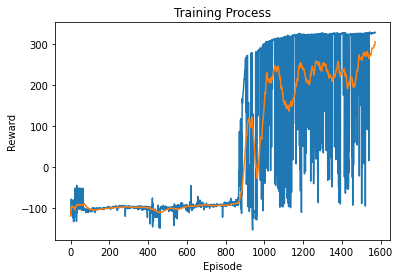

In [ ]:
# plot the training curve
plot_reward(total_reward_history, avg_reward_history, "./train_process.png")

### 6. play with trained Twin-Delayed DDPG agent

- After training, the simulation videos are saved in folder "./after_train", and the result looks like the following:
<p align="center">
  <img src="https://github.com/ChienTeLee/td3_bipedal_walker/raw/master/doc/after_train.gif" width="50%" height="50%"> 
</p>

- We can see that the Bipedal Walker is able to walk to the end of the terrain, and the average reward is around +300 points.

In [ ]:
env = gym.make("BipedalWalker-v3")
env = wrappers.Monitor(env, "./after_train", force=True, video_callable=lambda episode: (episode+1)>0)
total_reward_history = []

# play 5 trials with greedy move
for episode in range(5):
    state = env.reset()
    total_reward = 0
    done = 0

    while not done:
        action = td3_agent.choose_greedy_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

    total_reward_history.append(total_reward)

avg_reward = np.mean(total_reward_history)
print("Average reward after training = {}".format(avg_reward))
print ("End Playing")
env.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Average reward after training = 328.0723454205537
End Playing


In [ ]:
video_path = "./after_train"
play_video(video_path)

In [ ]:
#save result to zip file
!zip -r output.zip ./before_train ./during_train ./after_train train_process.png

  adding: before_train/ (stored 0%)
  adding: before_train/openaigym.manifest.0.123.manifest.json (deflated 71%)
  adding: before_train/openaigym.video.0.123.video000003.meta.json (deflated 60%)
  adding: before_train/openaigym.episode_batch.0.123.stats.json (deflated 43%)
  adding: before_train/openaigym.video.0.123.video000000.mp4 (deflated 6%)
  adding: before_train/openaigym.video.0.123.video000002.mp4 (deflated 3%)
  adding: before_train/openaigym.video.0.123.video000004.meta.json (deflated 60%)
  adding: before_train/openaigym.video.0.123.video000001.meta.json (deflated 60%)
  adding: before_train/openaigym.video.0.123.video000004.mp4 (deflated 3%)
  adding: before_train/openaigym.video.0.123.video000001.mp4 (deflated 5%)
  adding: before_train/openaigym.video.0.123.video000002.meta.json (deflated 60%)
  adding: before_train/openaigym.video.0.123.video000000.meta.json (deflated 60%)
  adding: before_train/openaigym.video.0.123.video000003.mp4 (deflated 4%)
  adding: during_train/